# Me conecto al Drive donde tengo los archivos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# We'll need to update our path to import from Drive.
import sys
sys.path.append('/content/drive/MyDrive/2021_DMCT/datos_eeg/procesados')

## Importa paquetes

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.signal import butter, lfilter
from sklearn import decomposition



In [4]:
!pip install mne
import mne

In [5]:
#%%
# Arma montaje
# Form the 10-20 montage
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep 
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Keep only the desired channels
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

In [6]:
def locmax(x):
    dx = np.diff(x) # discrete 1st derivative
    zc = np.diff(np.sign(dx)) # zero-crossings of dx
    m = 1 + np.where(zc == -2)[0] # indices of local max.
    return m




# Funciones

In [7]:
#%% Calculo GFP

def calculo_gfp(data,srate,do_plot):
    gfp = np.std(data, axis=0)
    gfp_peaks = locmax(gfp)
    gfp_values = gfp[gfp_peaks]
    gfp2 = np.sum(gfp_values**2) # normalizing constant in GEV
    n_gfp = gfp_peaks.shape[0]
    if do_plot=='yes':
        marcasx = np.arange(3)*srate
        xlab    = ['0','1','2']
        plt.plot(np.arange(len(gfp)),gfp,c='k')
        plt.scatter(gfp_peaks,gfp_values,c='r')
        plt.xlim(0,srate*3)
        plt.xticks(marcasx,xlab)
        plt.xlabel('Tiempo (s)')
        plt.ylabel('GFP')
        plt.show()
    return gfp,gfp_peaks,gfp_values,gfp2,n_gfp


In [8]:

# k means modificado
def kmeans2(gfp_maps, n_maps, n_runs=10, maxerr=1e-6, maxiter=500):
 
  V = gfp_maps.T
  n_gfp = V.shape[0]
  n_ch = V.shape[1]
  sumV2 = np.sum(V**2)

  # Guarda resultados de cada corrida
  cv_list =   []  # cross-validation criterion for each k-means run
  maps_list = []  # microstate maps for each k-means run
  L_list =    []  # microstate label sequence for each k-means run
  
  for run in range(n_runs):
    # initialize random cluster centroids 
    rndi = np.random.permutation(n_gfp)[:n_maps]
    maps = V[rndi, :]
    # normalize row-wise (across EEG channels)
    maps /= np.sqrt(np.sum(maps**2, axis=1, keepdims=True))
    # initialize
    n_iter = 0
    var0 = 1.0
    var1 = 0.0
    # convergence criterion: variance estimate (step 6)
    while ( (np.abs((var0-var1)/var0) > maxerr) & (n_iter < maxiter) ):
      # (step 3) microstate sequence (= current cluster assignment)
      C = np.dot(V, maps.T)
      C /= (n_ch*np.outer(gfp[gfp_peaks], np.std(maps, axis=1)))
      L = np.argmax(C**2, axis=1)
      # (step 4)
      for k in range(n_maps):
        Vt = V[L==k, :]
        # (step 4a)
        Sk = np.dot(Vt.T, Vt)
        # (step 4b)
        evals, evecs = np.linalg.eig(Sk)
        v = evecs[:, np.argmax(np.abs(evals))]
        v = v.real
        maps[k, :] = v/np.sqrt(np.sum(v**2))
        # (step 5)
        var1 = var0
        var0 = sumV2 - np.sum(np.sum(maps[L, :]*V, axis=1)**2)
        var0 /= (n_gfp*(n_ch-1))
        n_iter += 1
        if (n_iter > maxiter):
          print((f"\tK-means run {run+1:d}/{n_runs:d} did NOT converge "
                   f"after {maxiter:d} iterations."))
      # CROSS-VALIDATION criterion for this run (step 8)
    cv = var0 * (n_ch-1)**2/(n_ch-n_maps-1.)**2
    cv_list = np.append(cv_list,cv)
    maps_list.append(maps)
    L_list.append(L)
     
  # select best run. Lo elige en función del validación cruzada
  k_opt = np.argmin(cv_list)
  maps = maps_list[k_opt]
  L  = L_list[k_opt]
  cv = cv_list[k_opt] 
  return maps, L, cv

In [9]:
def silhoutte_modificado2(maps,data,labels,ch,n_clusters):
    if data.shape[0]!=ch:
       data=data.T
    elif maps.shape[0]!=ch:
       maps=maps.T
    
    corr_ctodos =np.abs(np.corrcoef(data.T))
    sil = []
    for n,i in enumerate(data.T):
        L = labels[n]
        dist = 1-corr_ctodos[n,:]
        dist_=np.delete(dist,n)
        lab_ = np.delete(labels,n)
        prom_dist=[]
        for k in range(n_clusters):
            prom_dist.append(np.mean(dist_[lab_==k]))
        a=prom_dist[L]
        b=np.min(np.delete(prom_dist,L))
        sil.append((b-a)/np.max([a,b]))
    return sil

In [10]:

#%% Grafico silhoutte
def grafica_sil(n_clusters,sil,labels):
    import matplotlib.cm as cm
    # Create a subplot with 1 row and 2 columns
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(labels) + (n_clusters + 1) * 10])

    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = np.mean(sil)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = np.array(sil)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
   # ax1.set_xticks([-1,-0.5,-0.2,0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

# Levanto datos de EEG
El registro de EEG de 30 canales viene en formato txt. La frecuencia de muestreo es de 128 Hz.

In [11]:
filename = '/content/drive/MyDrive/2021_DMCT/datos_eeg/procesados/suj_8_bl_2.txt'
datos = pd.read_csv(filename, sep=',', header=None)
EEGdata = datos.to_numpy()
srate=128
ch    = EEGdata.shape[0]
samples = EEGdata.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata.shape[1], EEGdata.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 128.00 Hz
Data shape: 7681 samples x 30 channels
Tiempo total : 60.01 


# Calculo GFP

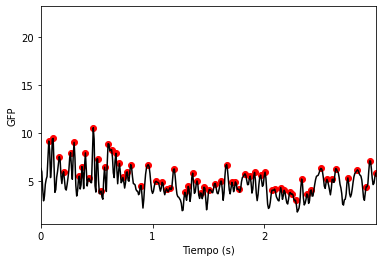

In [12]:
gfp,gfp_peaks,gfp_values,gfp2,n_gfp=calculo_gfp(EEGdata,srate,'yes')


# Miro los mapas de los picos de GFP

1337
(30, 5)


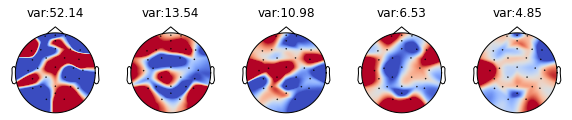

In [13]:
print(len(gfp_peaks))
X = EEGdata[:,gfp_peaks]
pca = decomposition.PCA(n_components=5)
pca.fit(X)
pcs = pca.transform(X)
print(pcs.shape)
var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', vmin=-100,vmax=100, contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )

# Calculo k-means modificado




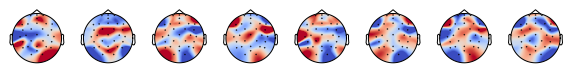

In [14]:
n_clusters =8
maps_kmeans,labels_gfp,cv = kmeans2(X, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

fig3, ax = plt.subplots(ncols=n_clusters, figsize=(10, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for n in range(n_clusters):
    mne.viz.plot_topomap(maps_kmeans[n,:].T,info_eeg,
                         vmin=-0.3,vmax=0.3, cmap='coolwarm',
                         contours=0, axes=ax[n],show=False)
   # ax[n].set_title('gev='+str(round(100*gev[n],1))+'%', fontweight='bold')
plt.show()



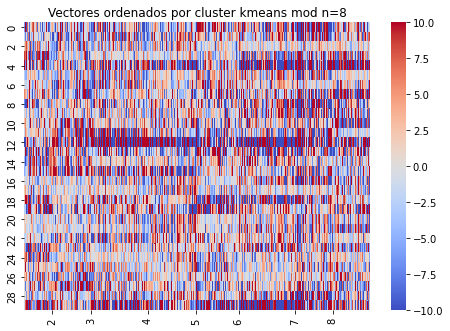

For n_clusters = 8 The average silhouette_score is : 0.1457280792668301


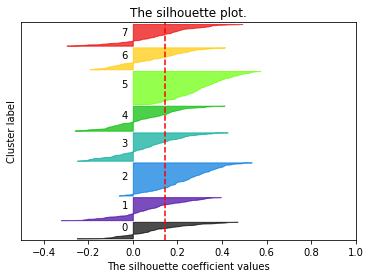

In [15]:
marcasx=np.array(np.where(np.diff(np.sort(labels_gfp))==1))

plt.figure()
plt.axes([0, 0, 1, 1])
sns.heatmap(X[:,np.argsort(labels_gfp)],vmin=-10,vmax=10, cmap='coolwarm')
plt.title('Vectores ordenados por cluster kmeans mod n=' + str(n_clusters))
plt.xticks(marcasx[0,:],labels=list(map(str, np.arange(2,n_clusters+1))))
plt.show()
sil = silhoutte_modificado2(maps_kmeans, X,labels_gfp, ch,n_clusters)
grafica_sil(n_clusters,sil,labels_gfp)